<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/OLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinary Least Squares

In this notebook we are going to explore the Ordinary Least Squares (OLS) method for linear regression. We will use the `statsmodels` library to perform the regression and explore its basic functionalities. We will also compare the results with the `pyfixest` library which is a faster alternative to `statsmodels` for the case of high-dimensional fixed effects models. Finally, we will explore the performance of OLS with high-dimensional covariates.

This notebook is based on the [Getting Started with Statsmodels](https://www.statsmodels.org/stable/gettingstarted.html), [OLS Example with Statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html), and [Getting Started with PyFixest](https://py-econometrics.github.io/pyfixest/quickstart.html) tutorials.


In [3]:
!pip install pyfixest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.1
    Uninstalling seaborn-0.13.1:
      Successfully uninstalled seaborn-0.13.1


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pyfixest as pf

np.random.seed(42) #because we're doing simulations

%config InlineBackend.figure_format = "retina"

## OLS Estimation

Artificial data:

In [5]:
nsample = 100
x = np.linspace(0, 10, 100) #lowercase vector
X = np.column_stack((x, x ** 2)) #i.e, if x is education, X is a vector that includes x and x squared.
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

Our model needs an intercept so we add a column of 1s:

In [6]:
X.shape #these are the dimensions.

(100, 2)

In [7]:
X = sm.add_constant(X) #statsmodel doesn't add a constant by default.
y = np.dot(X, beta) + e #here you're taking the dot product to get your overall OLS model equation.

In [8]:
X.shape #now these are the new dimensions.

(100, 3)

Fit and summary:

(Use the `cov_type` argument to set the covariance estimator to use)

In [9]:
model = sm.OLS(y, X) #this is how we use statsmodels. We call the array.
res1 = model.fit(cov_type='HC1') #we always want to include robust heteroskedastic errors, HC1.
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.945e+06
Date:                Fri, 06 Sep 2024   Prob (F-statistic):          8.66e-251
Time:                        14:09:52   Log-Likelihood:                -131.47
No. Observations:                 100   AIC:                             268.9
Df Residuals:                      97   BIC:                             276.8
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9481      0.261      3.639      0.0

In [10]:
# Print out parameters, standard errors, and r-squared with 2 decimal places
print('Parameters:', res1.params.round(2))
print('Standard errors:', res1.bse.round(2))
print('R-squared:', res1.rsquared.round(2))


Parameters: [ 0.95  0.04 10.01]
Standard errors: [0.26 0.12 0.01]
R-squared: 1.0


We simulate artificial data with a non-linear relationship between x and y:

In [11]:
nsample = 50
sig = 0.5
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, np.sin(x), (x - 5) ** 2, np.ones(nsample))) #our dimensions would be 50 by 4, because n is 50 and X is comprised of 4 elements.
beta = [0.5, 0.5, -0.02, 5.0]

y_true = np.dot(X, beta)
y = y_true + sig * np.random.normal(size=nsample)

res2 = sm.OLS(y, X).fit(cov_type='HC1')

Draw a plot to compare the true relationship to OLS predictions

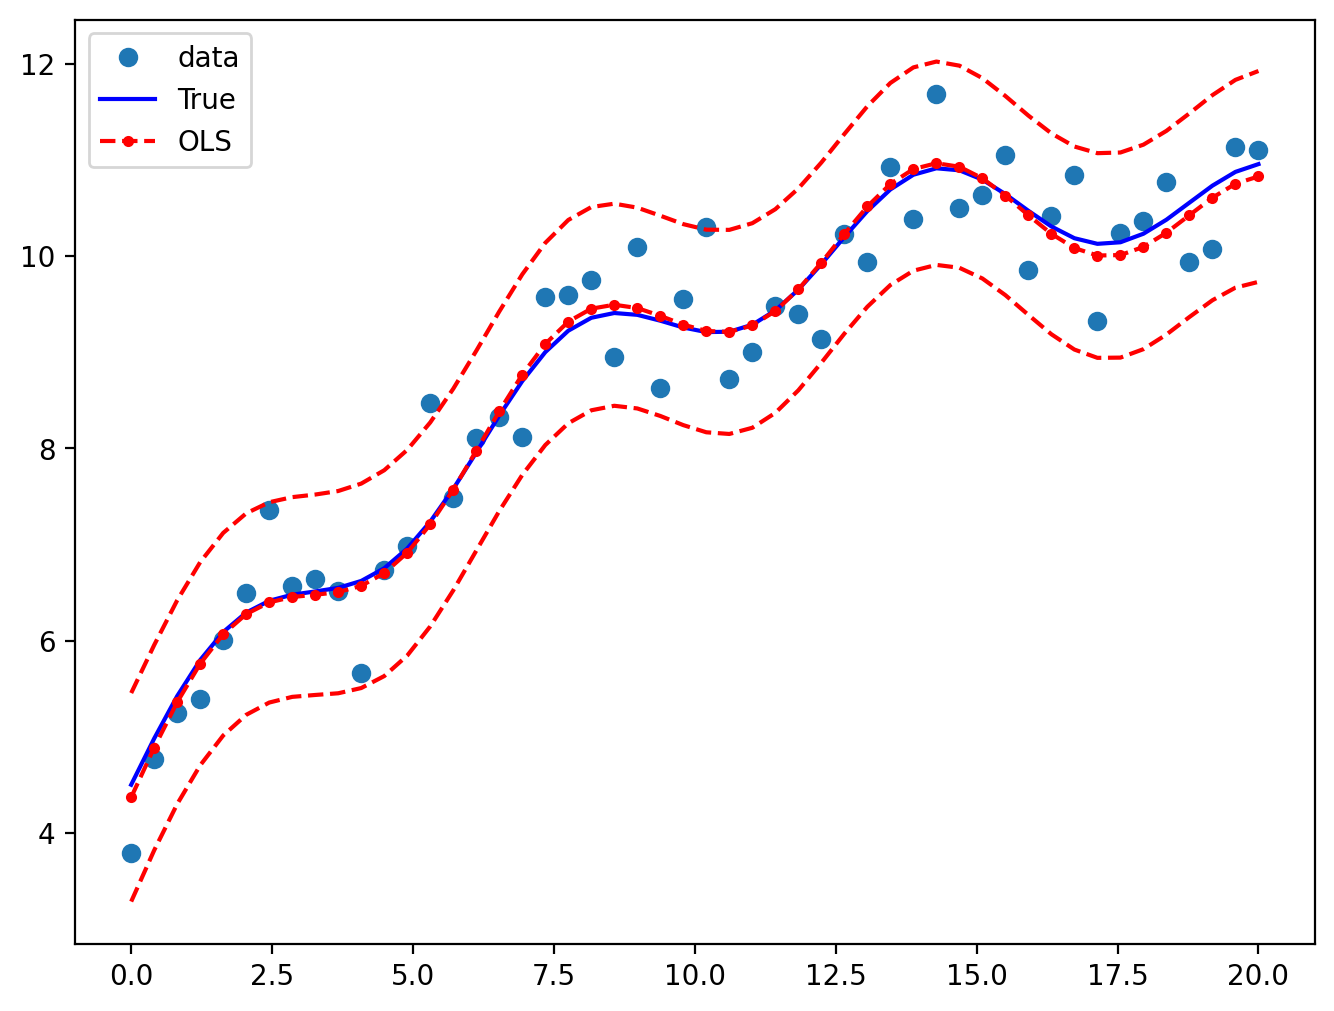

In [12]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"].values
iv_u = pred_ols.summary_frame()["obs_ci_upper"].values

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y, "o", label="data")
ax.plot(x, y_true, "b-", label="True")
ax.plot(x, res2.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

plt.show() #there is still linearity in the parameters. So OLS does a really good job at predicting, even if you have non linear functions.

## OLS with Fixed Effects

In [13]:
data = pf.get_data() #py fix es package was already imported. This is how we call it.

data.head()

,Y,Y2,X1,X2,f1,f2,f3,group_id,Z1,Z2,weights
0,NaN,2.357103,0.0,0.457858,15.0,0.0,7.0,9.0,-0.330607,1.054826,0.661478
1,-1.458643,5.163147,NaN,-4.998406,6.0,21.0,4.0,8.0,NaN,-4.113690,0.772732
2,0.169132,0.751140,2.0,1.558480,NaN,1.0,7.0,16.0,1.207778,0.465282,0.990929
3,3.319513,-2.656368,1.0,1.560402,1.0,10.0,11.0,3.0,2.869997,0.467570,0.021123
4,0.134420,-1.866416,2.0,-3.472232,19.0,20.0,6.0,14.0,0.835819,-3.115669,0.790815


In [14]:
data.info() #we get the types of each variable and see how many missing values we have.
#Here we have an issue... Group_id is categorical, so if we run it like this, python will interpret it as each id being better
#than the other. (Floats are decimals.) Therefore, we create dummies. Fixed effects.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         999 non-null    float64
 1   Y2        1000 non-null   float64
 2   X1        999 non-null    float64
 3   X2        1000 non-null   float64
 4   f1        999 non-null    float64
 5   f2        1000 non-null   float64
 6   f3        1000 non-null   float64
 7   group_id  1000 non-null   float64
 8   Z1        999 non-null    float64
 9   Z2        1000 non-null   float64
 10  weights   1000 non-null   float64
dtypes: float64(11)
memory usage: 86.1 KB


We are interested in the relation between the dependent variable `Y` and the independent variables `X1` using a fixed effect model for `group_id`. Let’s see how the data looks like:

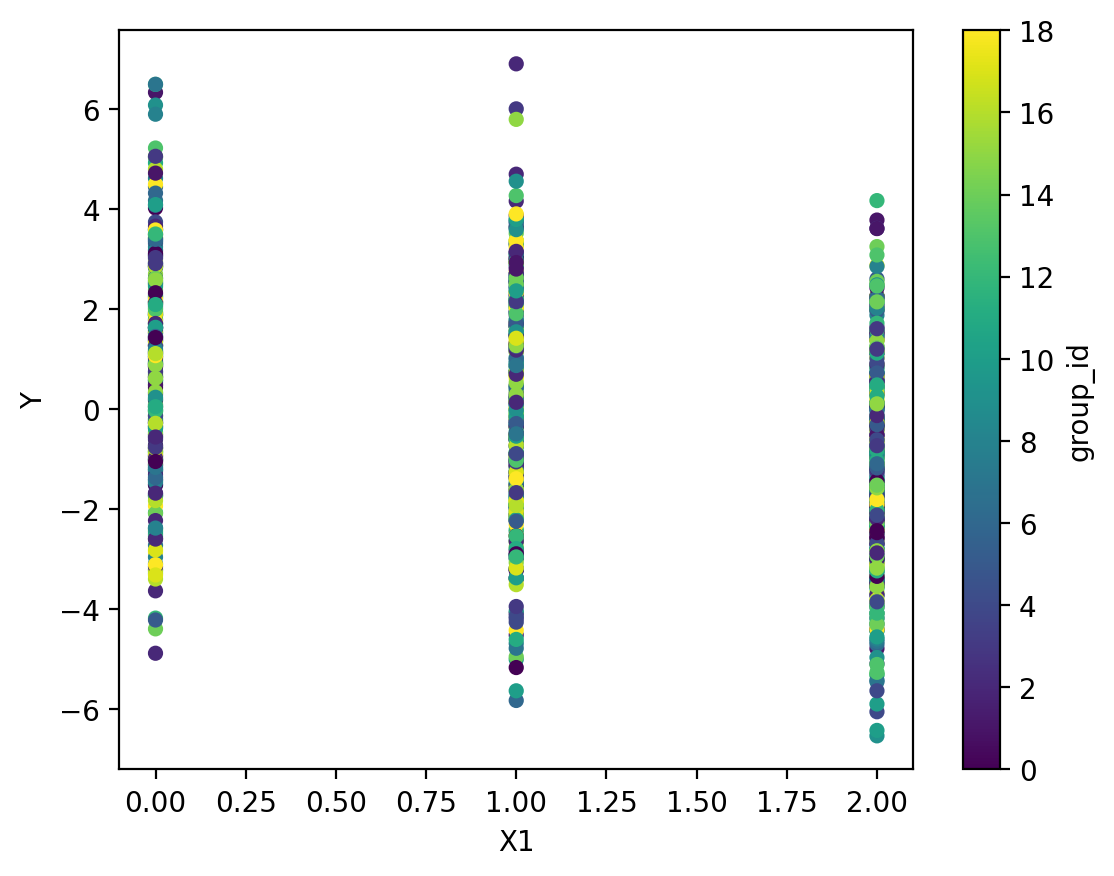

In [15]:
ax = data.plot(kind="scatter", x="X1", y="Y", c="group_id", colormap="viridis")

Using `pyfixest` we can estimate the fixed effects model:

In [16]:
res3 = pf.feols(fml="Y ~ X1 | group_id", data=data, vcov="HC1")
res3.summary() #thanks to this, you just call the variables you care about. You don't have to put together a matrix, or create dummies.
#pyfixest is built based on C. So it's similar to R fixest.

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.082 |   -12.352 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


We can also estimate the model using `statsmodels` formula API:

In [17]:
res4 = smf.ols("Y ~ X1 + C(group_id)", data=data).fit(cov_type='HC1')
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     8.529
Date:                Fri, 06 Sep 2024   Prob (F-statistic):           1.27e-22
Time:                        14:10:39   Log-Likelihood:                -2175.8
No. Observations:                 998   AIC:                             4392.
Df Residuals:                     978   BIC:                             4490.
Df Model:                          19                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.7604    

### To-do

In [ ]:
# Print the parameters and standard errors of X1 from res4


In [ ]:
# Instead of using the formula interface, we can also use the design matrix interface


## Multicollinearity

The Longley dataset is well known to have high multicollinearity. That is, the exogenous predictors are highly correlated.

In [18]:
from statsmodels.datasets.longley import load_pandas

y = load_pandas().endog
X = load_pandas().exog
X = sm.add_constant(X)

ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary()) #when the conditioning number becomes really large,
#that's an indicator of multicolinearity.

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Fri, 06 Sep 2024   Prob (F-statistic):           4.98e-10
Time:                        14:10:48   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.482e+06    8.9e+05     -3.911      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  res = hypotest_fun_out(*samples, **kwds)


#### Condition number

One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome (see Greene 4.9).

In [19]:
norm_x = X.values #if you have your array of covariates, X, you can calculate all of this cell.
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:, i] = X[name] / np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T, norm_x)

Then, we take the square root of the ratio of the biggest to the smallest eigen values.

In [20]:
eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

56240.87037739987


#### Dropping an observation

Greene also points out that dropping a single observation can have a dramatic effect on the coefficient estimates:

In [22]:
ols_results2 = sm.OLS(y.iloc[:14], X.iloc[:14]).fit()
print(
    "Percentage change %4.2f%%\n"
    * 7
    % tuple(
        [
            i
            for i in (ols_results2.params - ols_results.params)
            / ols_results.params
            * 100
        ]
    )
)

Percentage change 4.55%
Percentage change -105.20%
Percentage change -3.43%
Percentage change 2.92%
Percentage change 3.32%
Percentage change 97.06%
Percentage change 4.64%



## Overfitting

Example 1.2.1 (Overfitting Example) Suppose $X \sim N\left(0, I_p\right)$ and $Y \sim N(0,1)$ are statistically independent. It follows that the best linear predictor of $Y$ is $\beta^{\prime} X = 0$ and that $R_{pop}^2=0$.

- If $p=n$, then the typical $R_{\text {sample }}^2$ is $1 \gg 0$.
- If $p=n / 2$, then the typical $R_{\text {sample }}^2$ is about $.5 \gg 0$.
- If $p=n / 20$, then the typical $R_{\text {sample }}^2$ is about $.05>0$.

These results can be deduced by simulation or analytically.

In [25]:
n = 100
p = int(n/1) #change denominator for 1, 2, and 20
X = np.random.normal(size=(n, p))
y = np.random.normal(size=(n, 1))
res = sm.OLS(y, X).fit()

print(f"p/n is {p/n if n != 0 else np.inf}")
print(f"R-squared is {res.rsquared.round(3)}") #Number from 0 to 1 telling you how much of variation
#in y is explained by x.
print(f"Adjusted R-squared is {res.rsquared_adj.round(3)}") #adjusted is taking into account
#the number of covariates.

p/n is 1.0
R-squared is 1.0
Adjusted R-squared is nan


/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1796: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
